In [1]:
%matplotlib inline

In [2]:
import os
import random
import itertools

import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns

import skimage.io
import skimage.feature

import cv2

from sklearn.utils import resample

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

from sklearn.pipeline import make_union, make_pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# setup
RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

IMAGE_SHAPE = (64, 64)
DATA_BASE_DIR = "./data/"

HOG_SETTINGS = {
    "image_shape" : IMAGE_SHAPE, 
    "cell_size" : (8, 8),
    "block_size" : (2, 2),
    "nbins" : 9
}

GLCM_SETTINGS = {
    "image_shape" : IMAGE_SHAPE,
    "distances" : [1],
    "angles" : [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2],
}

VERBOSE = 0
PARALLEL = 1

In [48]:
# helpers
def read_data(datadir, labels_filter = []):
    """
        read image paths and its labels
    """

    image_paths = []
    labels = []

    for label in os.listdir(datadir):
        images_dir = os.path.join(datadir, label)
        if not labels_filter or label in labels_filter:
            for image_path in os.listdir(images_dir):
                image_path_full = os.path.join(images_dir, image_path)
                image_paths.append(image_path_full)
                labels.append(label)
            
    return np.array(image_paths), np.array(labels)

def get_random_sample_for_label(arr, labels, label, size):
    """
        get random sample
    """
    
    # In order to get same sample every time when the function is called without restarting the kernel
    # always reseed random number generator
    np.random.seed(RANDOM_STATE)

    labels_idx = np.random.choice(
        np.where(labels == label)[0],
        size=size,
        replace=True)
    

    return arr[labels_idx]

def read_image_cv2_rgb(image_path, expected_size = None):
    """
        read an image with opencv
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if expected_size and image.shape != expected_size:
        image = cv2.resize(image, expected_size)

    return image

def read_image_cv2_gray(image_path, expected_size = None):
    """
        read an image with opencv
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if expected_size and image.shape != expected_size:
        image = cv2.resize(image, expected_size)

    return image

def read_images(image_paths, expected_size = None, reader=read_image_cv2_rgb):
    """
        read list of images with specific reader
    """
    images = []
    for image_path in image_paths:
        images.append(reader(image_path, expected_size))
        
    return np.array(images)


def get_images_grid(images, rows=2, cols=2):
    """ 
    return image grid as a single image 
    """
    heigth, width, channels = images[0].shape
    
    # padding
    if images.shape[0] < (rows*cols):
        delta = (rows*cols) - images.shape[0]
        images = np.concatenate([images, [np.zeros_like(images[0])] * delta])
    
    return images.reshape(rows, 
                          cols, 
                          heigth, 
                          width, 
                          channels
                         ).swapaxes(1,2
                                   ).reshape(rows*heigth, 
                                             width*cols, 
                                             channels)

def plot_images_grid(images, rows=2, cols=2, title="", cmap=None):
    """
    plot grid of images
    """
    img_grid = get_images_grid(images, rows, cols)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img_grid, cmap=cmap)
    plt.title(title)
    plt.show()
    

def plot_hog_features(images, hog_images):
    """
    plot hog image
    """
    result = []
    for image, hog_image in zip(images, hog_images):
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.axis("off")
        plt.imshow(image, cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title("HOG features")
        plt.imshow(1 - hog_image, cmap="gray")
        plt.axis("off")
        plt.show()

def plot_glcm_distribution(glcm_prop, labels, title, xlabel):
    """
        Plot distribution of glcm property
    """
    plt.figure(figsize=(7, 7))
    for label in np.unique(labels):
        glcm_prop_for_label = glcm_prop[np.where(labels == label)]
        plt.hist(glcm_prop_for_label.ravel(), bins='fd', alpha=0.3, label=label)
    
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()
        
    
def get_cv_results_as_pd(cv_results):
    """
    transform cv results to pandas.DataFrame
    """
    data  = pd.DataFrame(cv_results)
    data = pd.concat([data.drop(['params'], axis=1), data['params'].apply(pd.Series)], axis=1)
    data = data.apply(pd.to_numeric, errors="ignore")
    data["mean_train_test_score_difference"] = (data["mean_train_score"] - data["mean_test_score"]).apply(abs)
    return data.apply(pd.to_numeric).round(5)


def plot_validation_curve(cv_results, best_index):
    """
    plot cv results scores
    """
    plt.figure(figsize=(15, 5))
    plt.plot(cv_results.index, cv_results["mean_train_score"], label = "train score")
    plt.plot(cv_results.index, cv_results["mean_test_score"], label = "validation score")
    plt.axvline(best_index, label = "best score", color="red", linestyle='--')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel("Params index")
    plt.ylabel("Score")
    plt.title("Scores for each param combination")
    
    plt.show()
        
def print_cv_scores(grid_search, splits, param_idx):
    cv_results = grid_search.cv_results_
    print(f"Params: {cv_results['params'][param_idx]}")
    for split_id in range(splits):
            split_key_train = f"split{split_id}_train_score"
            split_key_test = f"split{split_id}_test_score"
            print(f"\tCV {split_id+1}/{splits} - train score: {cv_results[split_key_train][param_idx]}, test score: {cv_results[split_key_test][param_idx]}")
          
def train_model_grid_search_cv(estimator, name, param_grid, features_train, labels_train, kfold, n_jobs = 1, verbose=0):
    """
        Train or load model with GridSearchCV
    """
    model_file = name + ".pkl"
    grid_search = None
    if os.path.exists(model_file):
        grid_search = joblib.load(model_file)
    else: 
        grid_search = GridSearchCV(estimator=estimator, 
                                   param_grid=param_grid,
                                   cv=kfold,
                                   n_jobs=n_jobs,
                                   verbose=verbose,
                                   return_train_score=True,
                                   scoring="f1_micro")
    
        grid_search.fit(features_train, labels_train)
        
        joblib.dump(grid_search, model_file)
    
    print(f"Model best score: {grid_search.best_score_}")
    print(f"Model best params: {grid_search.best_params_}")
    print()
    print(f"Mean fit time: {grid_search.cv_results_['mean_fit_time'].mean().round(3)}s")
    print(f"Mean score time: {grid_search.cv_results_['mean_score_time'].mean().round(3)}s")
    print()
    print_cv_scores(grid_search, kfold.n_splits, grid_search.best_index_)
    
    return grid_search 

# Image Scene Classification

## Introduction

Extracting features and train a machine learning model which classify scene of the image.

## Reading images and lables

In [5]:
# read images and its labels
# 1 to 1 relation between images and labels

image_paths, labels = read_data(DATA_BASE_DIR)

print(f"images size: {len(image_paths)}")
print(f"labels size: {len(labels)}")

images size: 11036
labels size: 11036


## Images exploration

In [6]:
unique_labels, lables_count = np.unique(labels, return_counts=True)

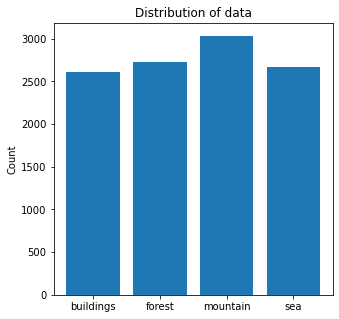

In [7]:
plt.figure(figsize=(5, 5))
plt.bar(unique_labels, lables_count)
plt.title("Distribution of data")
plt.ylabel("Count")
plt.show()

Dataset contains 4 labels. They are almost equaly distributed

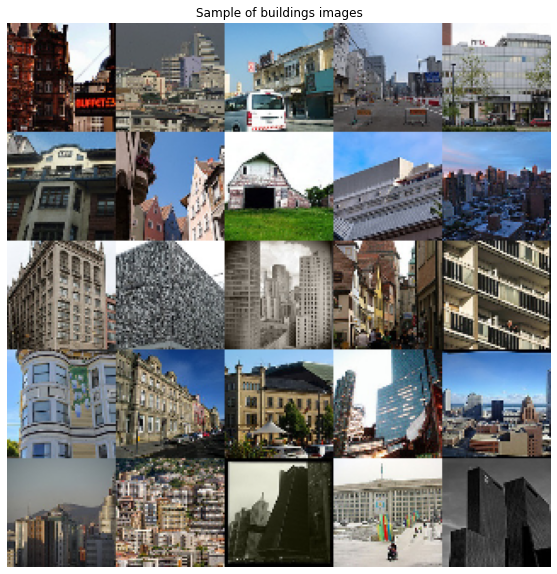

In [8]:
buildings_sample = get_random_sample_for_label(image_paths, labels, "buildings", 25)
buildings_images_sample = read_images(buildings_sample, IMAGE_SHAPE)

plot_images_grid(buildings_images_sample, 5, 5, "Sample of buildings images")

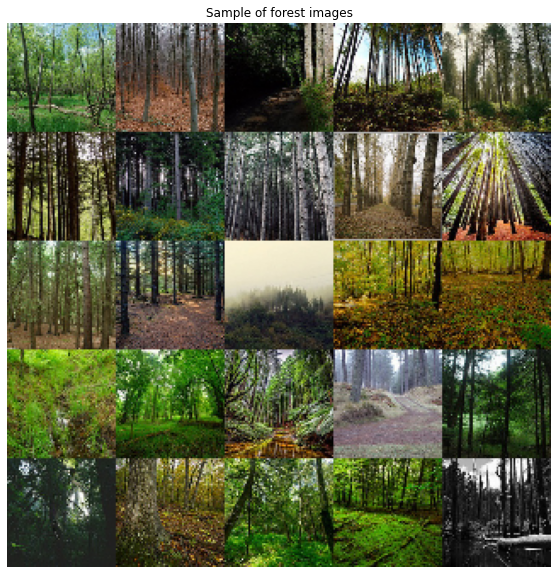

In [9]:
forest_sample = get_random_sample_for_label(image_paths, labels, "forest", 25)
forest_images_sample = read_images(forest_sample, IMAGE_SHAPE)

plot_images_grid(forest_images_sample, 5, 5, "Sample of forest images")

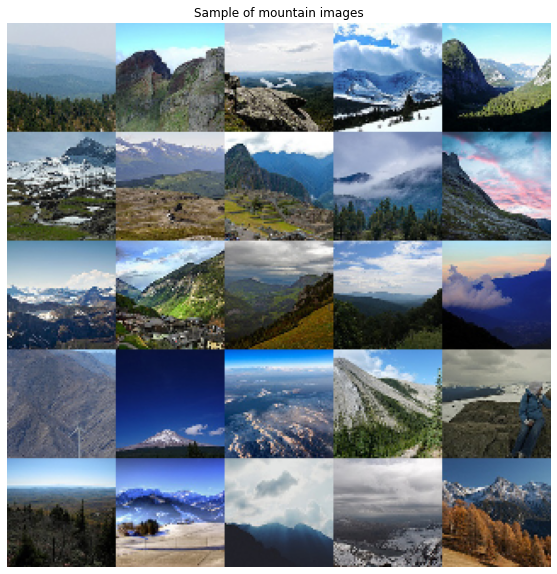

In [10]:
mountain_sample = get_random_sample_for_label(image_paths, labels, "mountain", 25)
mountain_images_sample = read_images(mountain_sample, IMAGE_SHAPE)

plot_images_grid(mountain_images_sample, 5, 5, "Sample of mountain images")

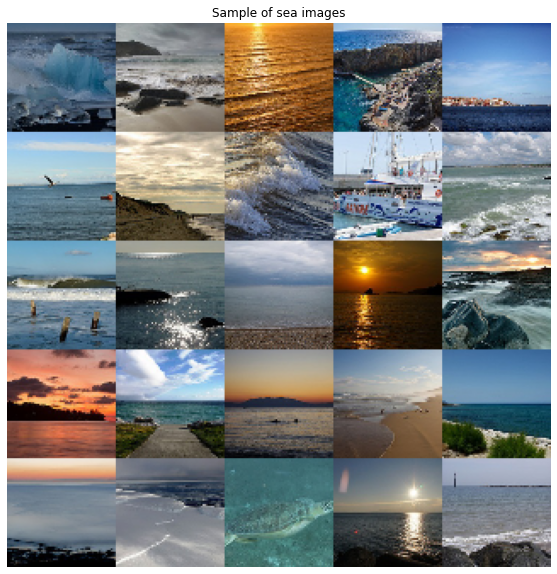

In [11]:
sea_sample = get_random_sample_for_label(image_paths, labels, "sea", 25)
sea_images_sample = read_images(sea_sample, IMAGE_SHAPE)
plot_images_grid(sea_images_sample, 5, 5, "Sample of sea images")

Dataset contain gray and colored images

## Feature Extraction

Extracting feature vectors from the images 

In [12]:
images = read_images(image_paths, IMAGE_SHAPE, read_image_cv2_gray)

In [13]:
images_train, images_test, labels_train, labels_test = train_test_split(images, 
                                                                       labels, 
                                                                       test_size=0.15, 
                                                                       stratify=labels,
                                                                       random_state=RANDOM_STATE)

images_train.shape, images_test.shape, labels_train.shape, labels_test.shape

((9380, 64, 64), (1656, 64, 64), (9380,), (1656,))

### Histograms of Oriented Gradients 

Extracting information about object shapes in the images

In [14]:
def skimage_hog_descriptor(image_shape, cell_size, block_size, nbins, **kw_args):
    
    def skimage_hog_wrapper(image):
        return skimage.feature.hog(image, 
                                   pixels_per_cell=cell_size, 
                                   cells_per_block=block_size,
                                   orientations=nbins,
                                   **kw_args)
    
    
    return skimage_hog_wrapper

def make_hog_descriptor(image_shape, cell_size, block_size, nbins, hog_type = "opencv", **kw_args):
    if hog_type == "opencv":
        return cv2.HOGDescriptor(_winSize=(image_shape[1] // cell_size[1] * cell_size[1],
                                           image_shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins,
                                **kw_args).compute

    return skimage_hog_descriptor(image_shape, cell_size, block_size, nbins, **kw_args)


def calculate_hog_descriptors(images, **kw_args):
    hog_descr = make_hog_descriptor(**kw_args)
    
    hog_vectors = []
    hog_images = []
    
    hasVisualize = "visualize" in kw_args
    
    for image in images:
        hog_result = hog_descr(image)
        
        if hasVisualize:
            hog_images.append(hog_result[1])
            hog_result = hog_result[0]
        
        hog_vectors.append(
            hog_result.ravel())
        
    return (np.array(hog_vectors), np.array(hog_images)) if hasVisualize else np.array(hog_vectors)

def make_hog_transformer(**kw_args):
    return FunctionTransformer(calculate_hog_descriptors,
                               kw_args=kw_args)


hog_extractor_opencv = make_hog_transformer(**HOG_SETTINGS,
                                            hog_type = "opencv")

hog_extractor_skimage = make_hog_transformer(**HOG_SETTINGS,
                                             hog_type = "skimage",
                                             visualize = True)

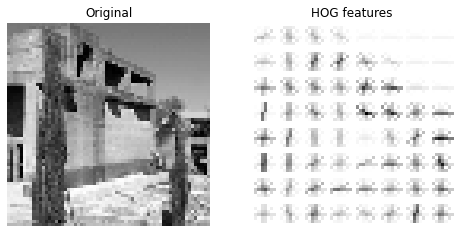

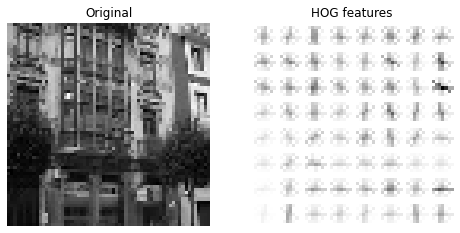

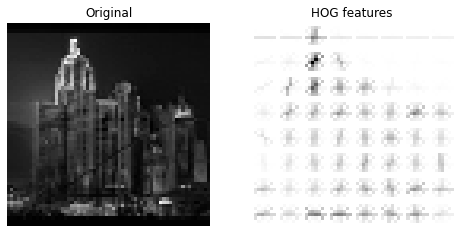

In [15]:
buildings_images_sample = get_random_sample_for_label(images_train, labels_train, "buildings", 3)
_, buidings_images_hog = hog_extractor_skimage.transform(buildings_images_sample)
plot_hog_features(buildings_images_sample, buidings_images_hog) 

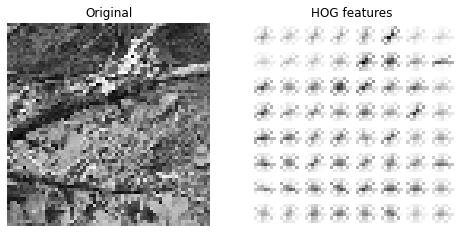

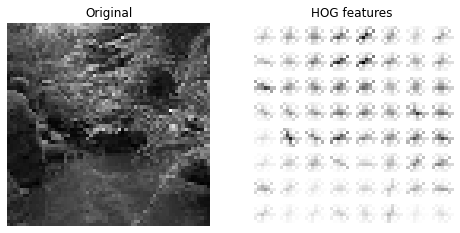

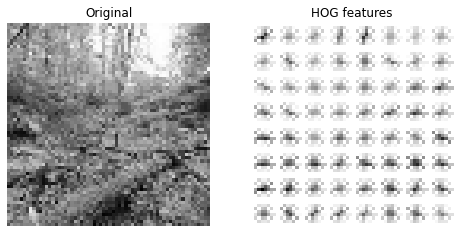

In [16]:
forest_images_sample = get_random_sample_for_label(images_train, labels_train, "forest", 3)
_, forest_images_hog = hog_extractor_skimage.transform(forest_images_sample)
plot_hog_features(forest_images_sample, forest_images_hog) 

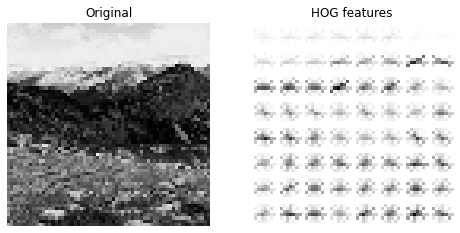

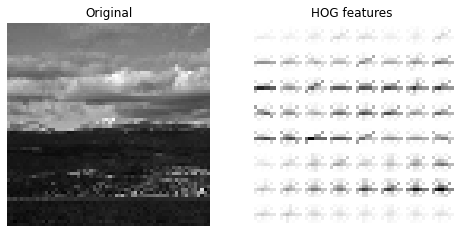

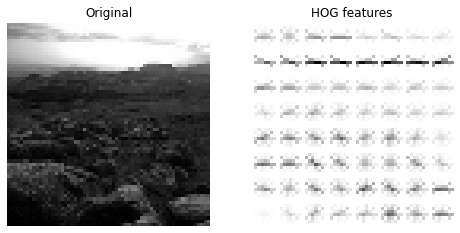

In [17]:
mountain_images_sample = get_random_sample_for_label(images_train, labels_train, "mountain", 3)
_, mountain_images_hog = hog_extractor_skimage.transform(mountain_images_sample)
plot_hog_features(mountain_images_sample, mountain_images_hog) 

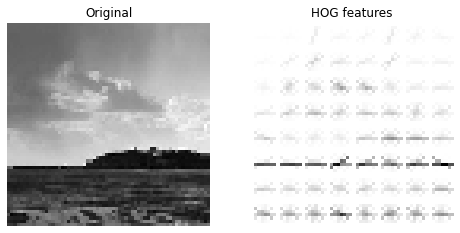

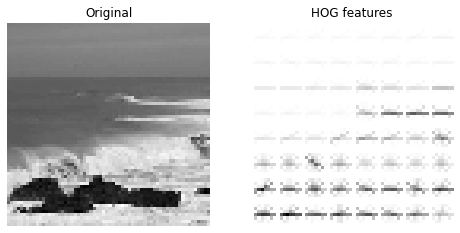

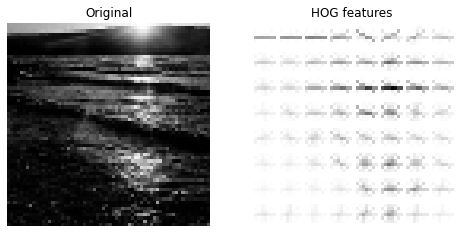

In [18]:
sea_images_sample = get_random_sample_for_label(images_train, labels_train, "sea", 3)
_, sea_images_hog = hog_extractor_skimage.transform(sea_images_sample)
plot_hog_features(sea_images_sample, sea_images_hog) 

hog descriptors  for *buildings* and *forest* are distinguishable but *mountain* and *sea* looks identical.

### Gray Level Co-occurrence Matrices

Extract relationships between pixels using properties calculated from gray level co-occurrence matrices

In [19]:
def calculate_greycoprop(images, image_shape, distances, angles, prop):
    result = []
    for image in images:
        glcm = skimage.feature.greycomatrix(image, distances, angles)
        greycoprop = skimage.feature.greycoprops(glcm, prop)
        
        result.append(greycoprop.ravel())
        
    return np.array(result)

def make_glcm_transformer(**kw_args):
    return FunctionTransformer(calculate_greycoprop,
                               kw_args=kw_args)

glcm_extractor_dissimilarity = make_glcm_transformer(**GLCM_SETTINGS, prop="dissimilarity")
glcm_extractor_correlation = make_glcm_transformer(**GLCM_SETTINGS, prop="correlation")

In [20]:
glcm_diss = glcm_extractor_dissimilarity.transform(images_train)

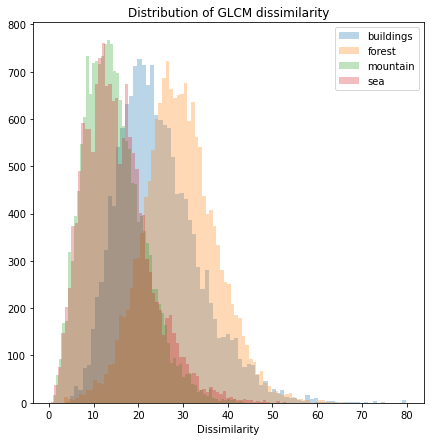

In [21]:
plot_glcm_distribution(glcm_diss, labels_train, "Distribution of GLCM dissimilarity", "Dissimilarity")

In [22]:
glcm_corr = glcm_extractor_correlation.transform(images_train)

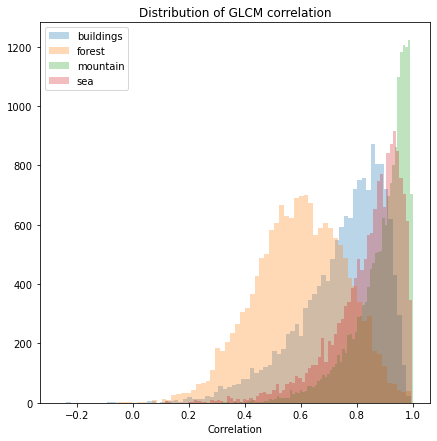

In [23]:
plot_glcm_distribution(glcm_corr, labels_train, "Distribution of GLCM correlation", "Correlation")

Again distributions for mountain and sea properties looks similar.

### Feature extractions pipeline

In [24]:
features_extractors = make_union(hog_extractor_opencv, 
                                 glcm_extractor_dissimilarity, 
                                 glcm_extractor_correlation)

# Used for PCA traing
features_train = features_extractors.transform(images_train)

In [25]:
features_train.shape

(9380, 1778)

## Dimensionality Reduction

In [26]:
pca = PCA()
scaler = MinMaxScaler()

features_train_pca = pca.fit_transform(
    scaler.fit_transform(
        features_train)
)

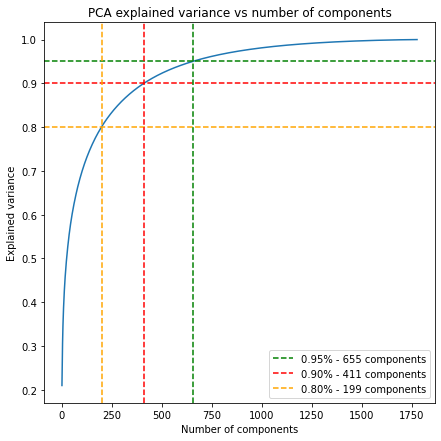

In [27]:
explained_variance_ratio_sum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(7, 7))

plt.plot(range(features_train.shape[1]), explained_variance_ratio_sum)

plt.axhline(0.95, c="green", linestyle="--", 
            label=f"0.95% - {np.where(explained_variance_ratio_sum > 0.95)[0][0] + 1} components")

plt.axhline(0.90, c="red", linestyle="--", 
            label=f"0.90% - {np.where(explained_variance_ratio_sum > 0.90)[0][0] + 1} components" )

plt.axhline(0.80, c="orange", linestyle="--", 
            label=f"0.80% - {np.where(explained_variance_ratio_sum > 0.80)[0][0] + 1} components" )


plt.axvline(np.where(explained_variance_ratio_sum >= 0.95)[0][0] + 1, color="green", linestyle="--")
plt.axvline(np.where(explained_variance_ratio_sum >= 0.90)[0][0] + 1, color="red", linestyle="--")
plt.axvline(np.where(explained_variance_ratio_sum >= 0.80)[0][0] + 1, color="orange", linestyle="--")

plt.legend()
plt.title("PCA explained variance vs number of components")
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

With 80% variance feature vector size is reduced to 199

### PCA pipeline

In [28]:
pca_pipeline = make_pipeline(
    MinMaxScaler(),
    PCA(n_components=0.80)) 

In [29]:
# Used in models training
features_train_pca = pca_pipeline.fit_transform(features_train)

In [30]:
features_train.shape, features_train_pca.shape

((9380, 1778), (9380, 199))

## Models Training

In [31]:
# Use same kfold strategy for all models
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

### Logistic Regression

In [32]:
param_grid = {
    "C" : np.geomspace(0.01, 100, 20)
}


lr_grid_search = train_model_grid_search_cv(LogisticRegression(solver='liblinear'),
                                            "logistic_regression",
                                            param_grid,
                                            features_train_pca,
                                            labels_train,
                                            kfold=kfold,
                                            n_jobs=PARALLEL,
                                            verbose=VERBOSE)

lr_cv_results = get_cv_results_as_pd(lr_grid_search.cv_results_)

Model best score: 0.7847546561456799
Model best params: {'C': 2.06913808111479}

Mean fit time: 1.216s
Mean score time: 0.019s

Params: {'C': 2.06913808111479}
	CV 1/3 - train score: 0.8207260514952822, test score: 0.7927726255196675
	CV 2/3 - train score: 0.8208859747321287, test score: 0.7780620402942116
	CV 3/3 - train score: 0.820434921650144, test score: 0.7834293026231605


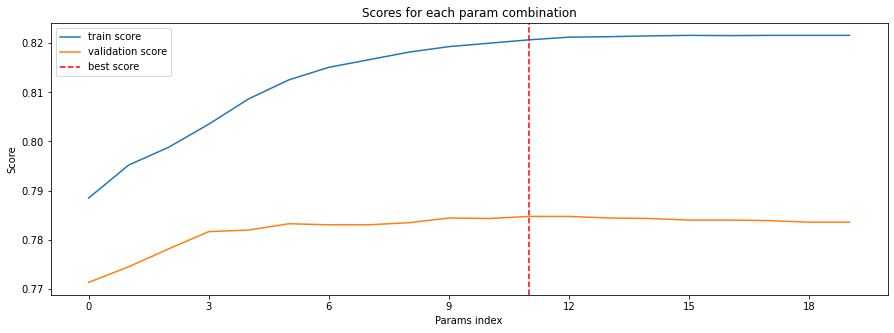

In [33]:
plot_validation_curve(lr_cv_results, lr_grid_search.best_index_)

### Linear SVM

In [34]:
param_grid = {
    "C" : np.geomspace(0.01, 100, 20),
    "max_iter" : [5000]
}


lsvc_grid_search = train_model_grid_search_cv(LinearSVC(),
                                            "linear_svc",
                                            param_grid,
                                            features_train_pca,
                                            labels_train,
                                            kfold=kfold,
                                            n_jobs=PARALLEL,
                                            verbose=VERBOSE)

lsvc_cv_results = get_cv_results_as_pd(lsvc_grid_search.cv_results_)

Model best score: 0.7817695587172259
Model best params: {'C': 14.38449888287663, 'max_iter': 5000}

Mean fit time: 56.515s
Mean score time: 0.021s

Params: {'C': 14.38449888287663, 'max_iter': 5000}
	CV 1/3 - train score: 0.8157684311530464, test score: 0.7866965142308923
	CV 2/3 - train score: 0.8154485846793539, test score: 0.7783818356251999
	CV 3/3 - train score: 0.81675727534378, test score: 0.7802303262955853


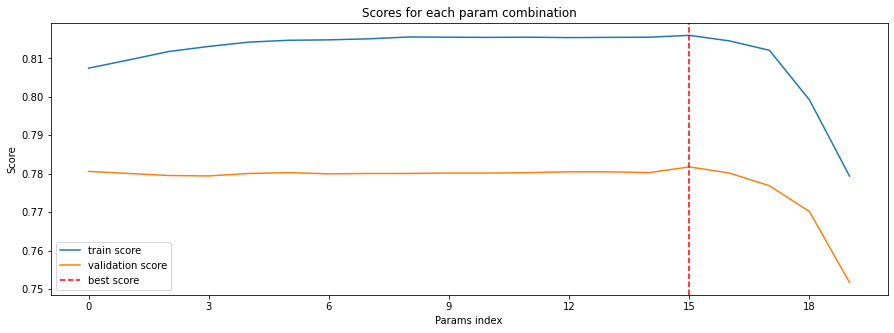

In [35]:
plot_validation_curve(lsvc_cv_results, lsvc_grid_search.best_index_)

Linear SVM and Logistics Regression models have almost same results but Logistics Regression model is faster. 

### Kernel SVM

In [36]:
param_grid = {
    "C" : np.geomspace(0.01, 500, 20),
    "gamma" : np.geomspace(0.0001, 10, 10)
}

svc_rbf_search = train_model_grid_search_cv(SVC(),
                                            "svc_rbf",
                                            param_grid,
                                            features_train_pca,
                                            labels_train,
                                            kfold=kfold,
                                            n_jobs=PARALLEL,
                                            verbose=VERBOSE)

svc_rbf_cv_results = get_cv_results_as_pd(svc_rbf_search.cv_results_)

Model best score: 0.8443499039693291
Model best params: {'C': 2.9726385636974184, 'gamma': 0.016681005372000592}

Mean fit time: 23.552s
Mean score time: 10.143s

Params: {'C': 2.9726385636974184, 'gamma': 0.016681005372000592}
	CV 1/3 - train score: 0.9668958899728131, test score: 0.8397825391749281
	CV 2/3 - train score: 0.9694546617623541, test score: 0.8468180364566678
	CV 3/3 - train score: 0.9688199552286536, test score: 0.8464491362763915


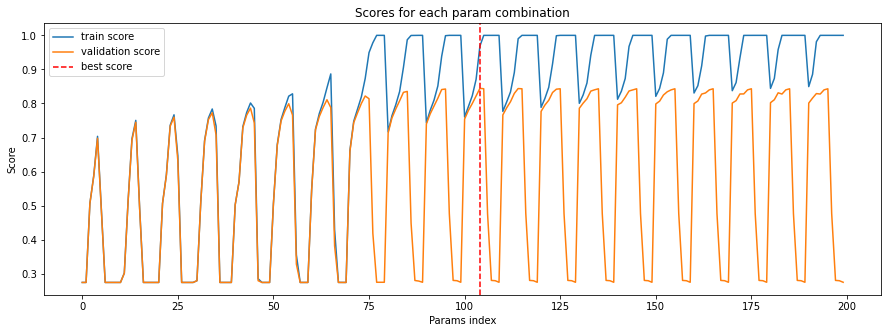

In [37]:
plot_validation_curve(svc_rbf_cv_results, svc_rbf_search.best_index_)

Best score overfits the data so let's try to shrink the param grid

In [38]:
param_grid = {
    "C" : np.geomspace(0.01, 0.5, 5),
    "gamma" : [0.02],
    "probability" : [True]
}

svc_rbf_search_retuned = train_model_grid_search_cv(SVC(),
                                                    "svc_rbf_retuned",
                                                    param_grid,
                                                    features_train_pca,
                                                    labels_train,
                                                    kfold=kfold,
                                                    n_jobs=PARALLEL,
                                                    verbose=VERBOSE)

svc_rbf_cv_results_retuned = get_cv_results_as_pd(svc_rbf_search_retuned.cv_results_)

Model best score: 0.8199373599446153
Model best params: {'C': 0.5, 'gamma': 0.02, 'probability': True}

Mean fit time: 118.303s
Mean score time: 9.87s

Params: {'C': 0.5, 'gamma': 0.02, 'probability': True}
	CV 1/3 - train score: 0.8795778026547257, test score: 0.8132395267029101
	CV 2/3 - train score: 0.8818167279705741, test score: 0.8141989126958746
	CV 3/3 - train score: 0.8757595139110969, test score: 0.8323736404350608


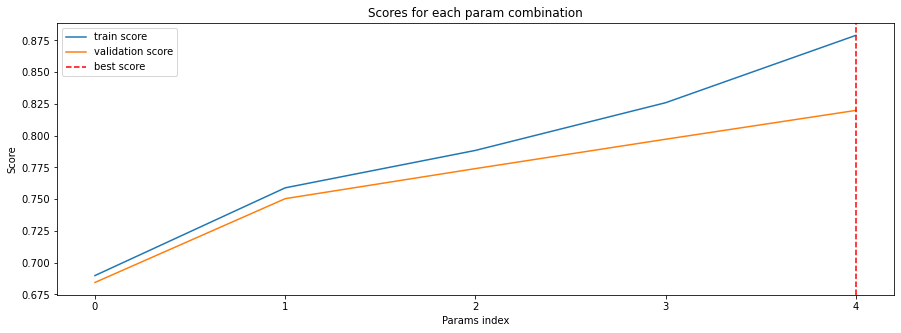

In [39]:
plot_validation_curve(svc_rbf_cv_results_retuned, svc_rbf_search_retuned.best_index_)

SVM model with RBF kernel has best results so lets use it to check how it performs on the testing data

### Final Pipeline

In [40]:
final_model = make_pipeline(features_extractors, 
                            pca_pipeline, 
                            svc_rbf_search_retuned.best_estimator_)

## Results

In [41]:
predictions = final_model.predict(images_test)
predictions_probabilities = final_model.predict_proba(images_test)

In [42]:
print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

   buildings       0.89      0.87      0.88       391
      forest       0.92      0.95      0.93       409
    mountain       0.76      0.78      0.77       455
         sea       0.75      0.71      0.73       401

    accuracy                           0.83      1656
   macro avg       0.83      0.83      0.83      1656
weighted avg       0.83      0.83      0.83      1656



The final model has 83% accuracy and 0.83 F1 score.

In [43]:
cm = confusion_matrix(labels_test, predictions, labels=np.unique(labels_test))

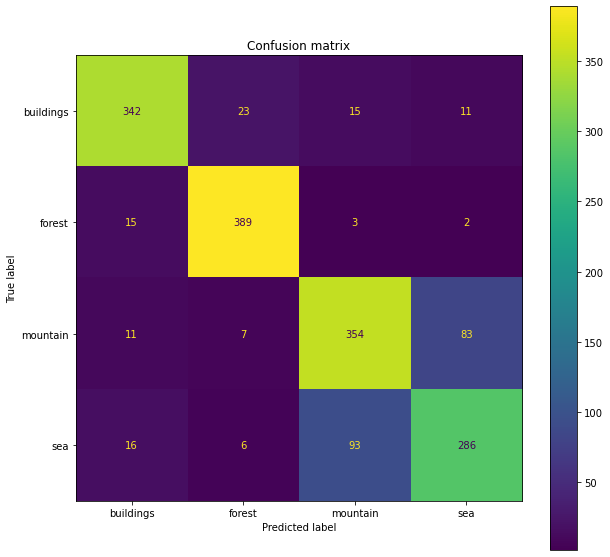

In [44]:
plt.figure(figsize=(10, 10))
plt.title("Confusion matrix")
cm_display = ConfusionMatrixDisplay(cm, display_labels=np.unique(labels_test))

cm_display.plot(ax=plt.gca())
plt.show()

Almost all *buildings* and *forest* images are classified correctly.
There are more missclasifield *moutain* and *sea* images because they have similar features.

Let's see some of the correct and some of the wrong classifications

In [45]:
# for easier selections convert predictions to pandas DataFrame

prediction_data = pd.DataFrame(predictions_probabilities)
prediction_data["prediction"] = predictions
prediction_data["label"] = labels_test

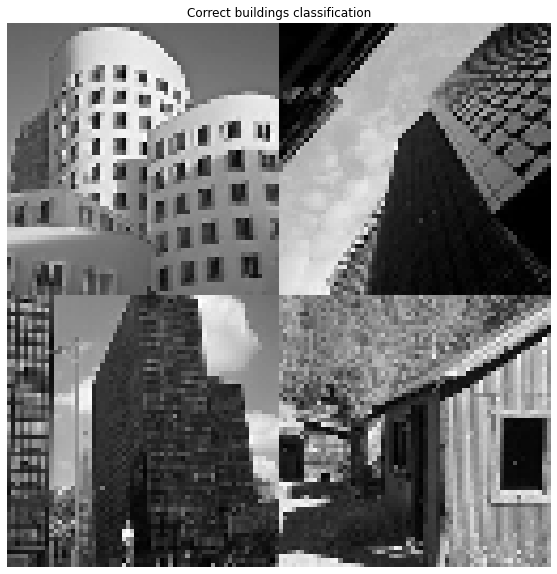

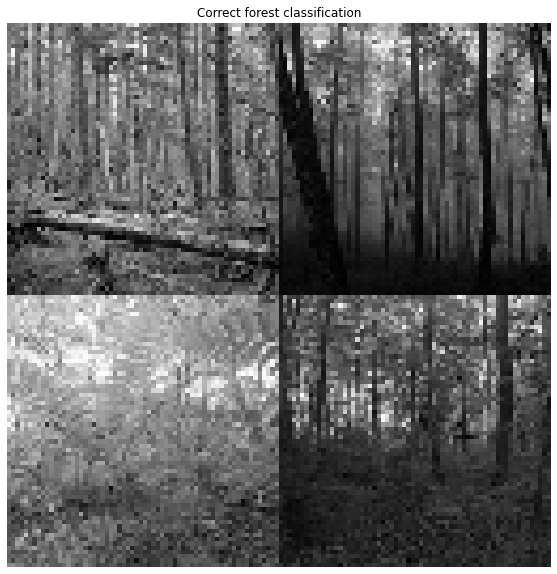

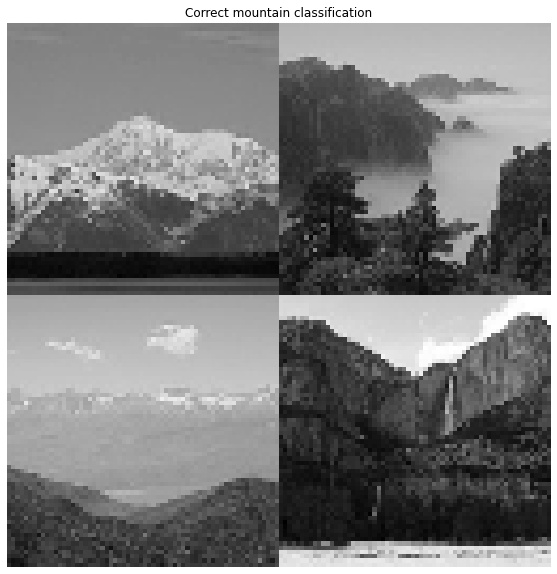

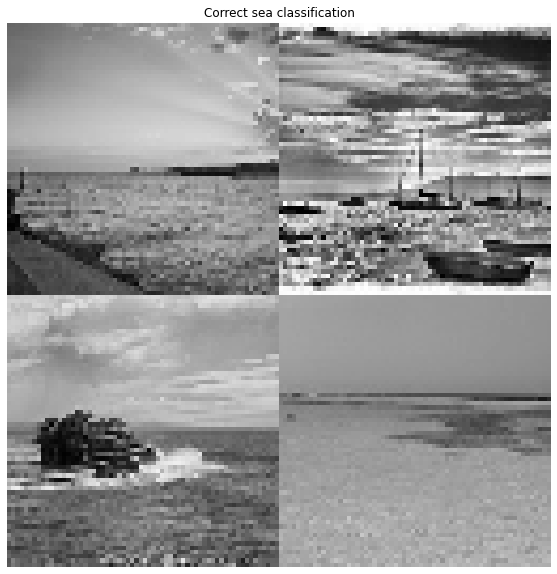

In [46]:
for label in unique_labels:
    correct_mask = prediction_data[
    (prediction_data.label == label) & 
    (prediction_data.prediction == label)].index

    correct_sample = images_test[correct_mask][:4].reshape(-1, *IMAGE_SHAPE, 1)
    plot_images_grid(correct_sample, 2, 2, f"Correct {label} classification", cmap="gray")

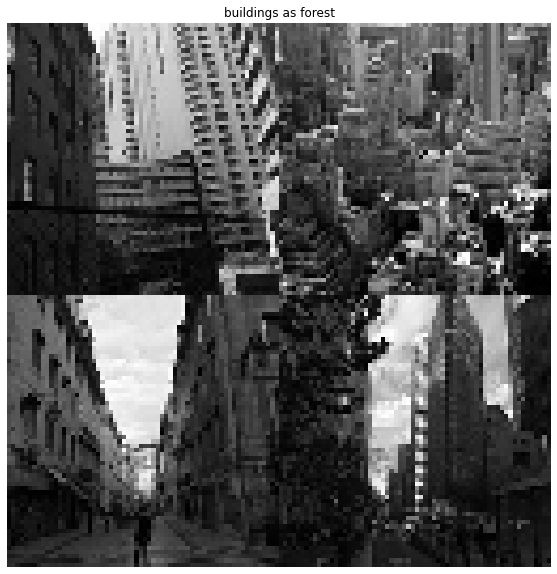

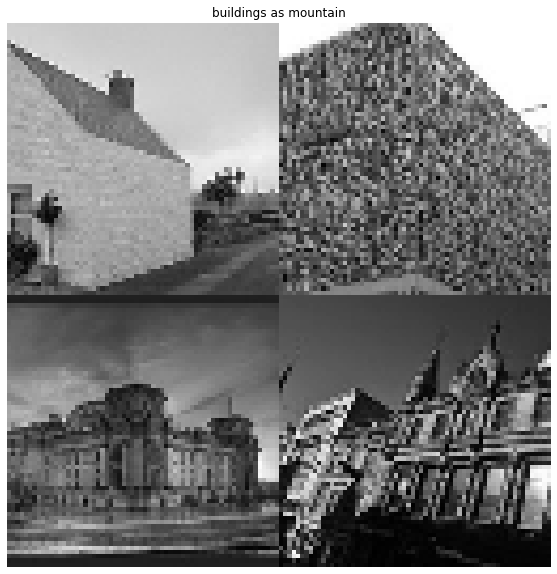

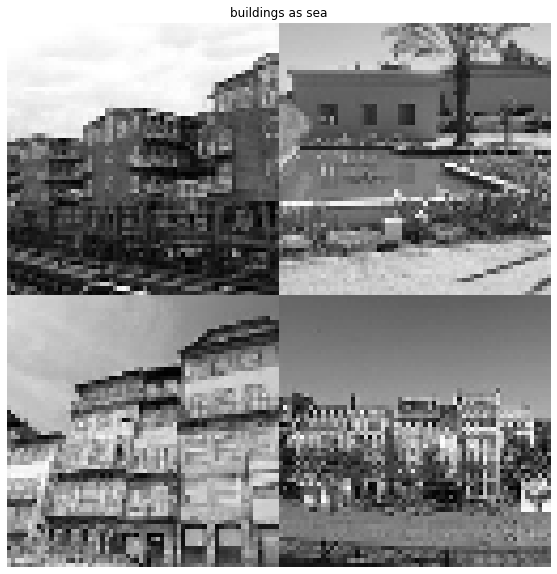

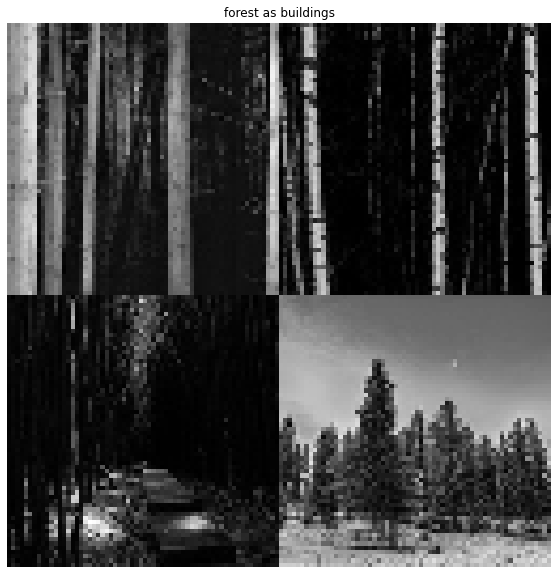

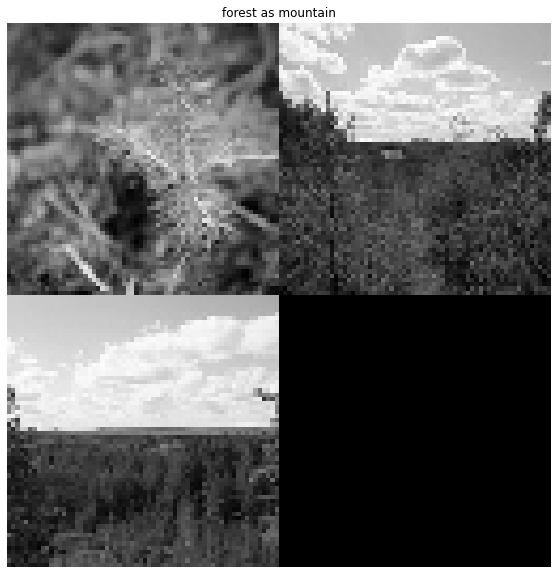

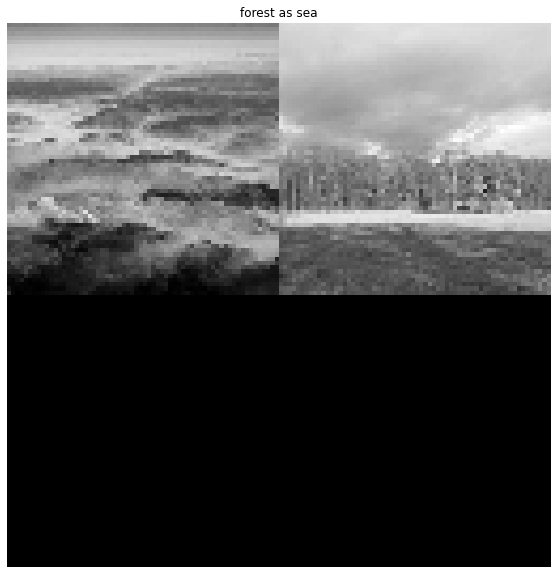

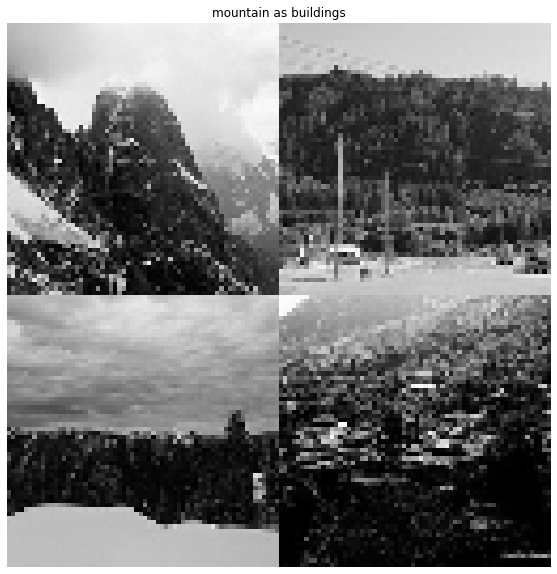

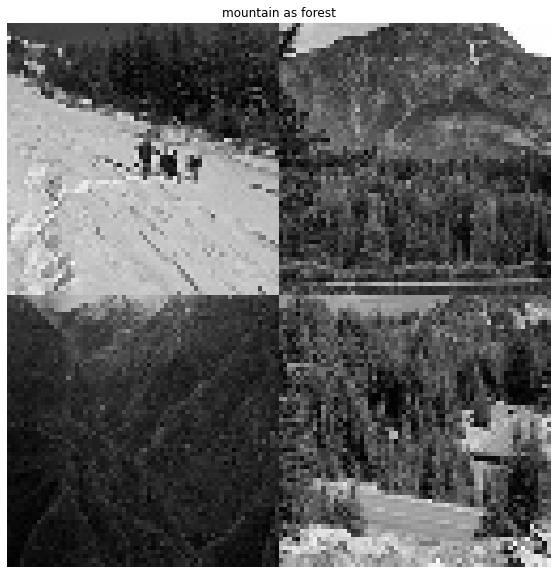

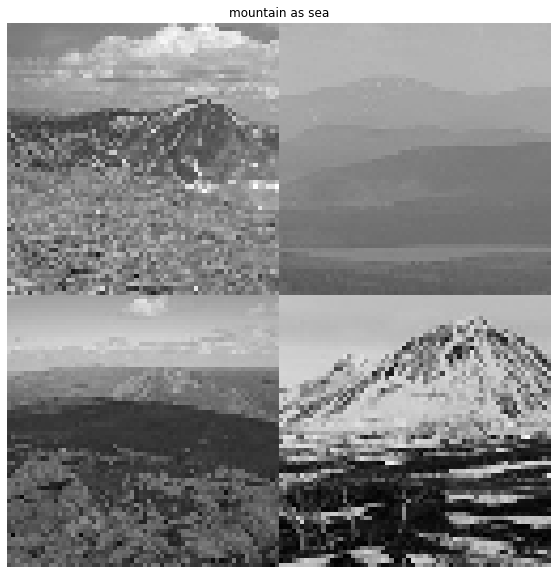

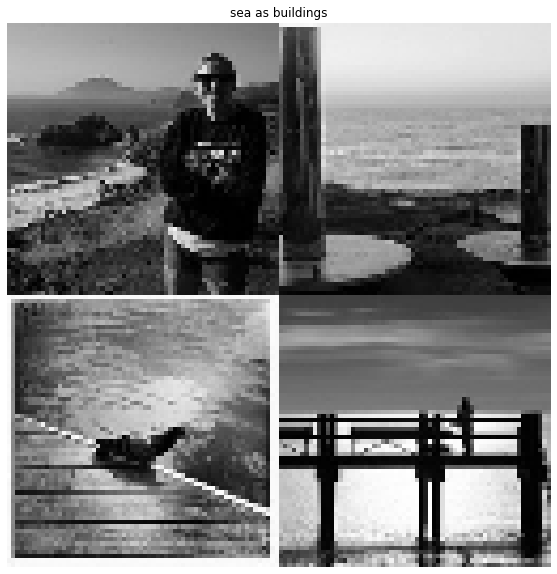

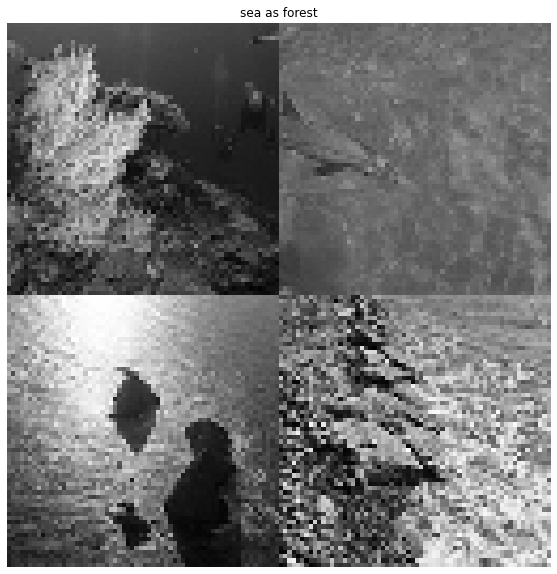

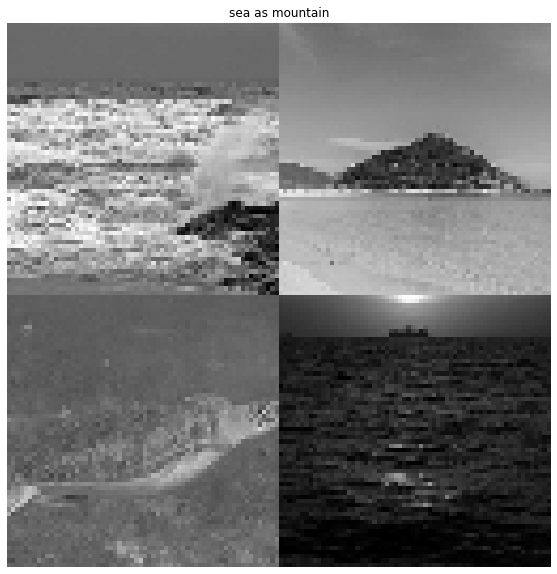

In [47]:
for label, prediction in itertools.permutations(unique_labels, 2):
    correct_mask = prediction_data[
    (prediction_data.label == label) & 
    (prediction_data.prediction == prediction)].index

    correct_sample = images_test[correct_mask][:4].reshape(-1, *IMAGE_SHAPE, 1)
    plot_images_grid(correct_sample, 2, 2, f"{label} as {prediction}", cmap="gray")


## Conclusion

In this notebook I successfully explored and extracted image features. These features were used to train different classifiers which classify image scenes. The final model could be improved with boosting and training with more data. Also Convolutional Neural Network could be traing in order to avoid feature extraction.

## References

- https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
- https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
- https://scikit-learn.org/stable/
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html